Note: This code was done in Google Colab
Note: GridSearchCV will take around an hour to run.

In [1]:
# Load packages
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy import sparse

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
# Load the datasets
train_df = pd.read_csv(r'project_adult.csv')
valid_df = pd.read_csv(r'project_validation_inputs.csv')

# Drop the saved index column if present
for df in (train_df, valid_df):
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
# Show first 10 rows of original training data
print("\nOriginal Training Data (first 10 rows):")
print(train_df.head(10))




Original Training Data (first 10 rows):
   age         workclass  fnlwgt     education  education-num  \
0   33         Local-gov  198183     Bachelors             13   
1   36           Private   86459     Assoc-voc             11   
2   58  Self-emp-not-inc  203039           9th              5   
3   21           Private  180190     Assoc-voc             11   
4   27           Private  279872  Some-college             10   
5   44           Private  175485     Bachelors             13   
6   33           Private   67006          10th              6   
7   62  Self-emp-not-inc   75478     Bachelors             13   
8   20           Private  374116       HS-grad              9   
9   33           Private   23871       HS-grad              9   

       marital-status         occupation    relationship   race     sex  \
0       Never-married     Prof-specialty   Not-in-family  White  Female   
1  Married-civ-spouse    Exec-managerial         Husband  White    Male   
2           Separa

In [4]:
# Separate features and target (keep ALL rows—both <=50K and >50K)
X_train_raw = train_df.drop(columns=["income"])
y_raw = train_df["income"]            # kept for later parts; Part 1 focuses on X
X_valid_raw = valid_df.copy()         # validation has no label

# Identify numeric and categorical feature columns
numeric_cols = X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train_raw.select_dtypes(include=["object"]).columns.tolist()

print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")



Numeric columns (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


# Part 1a: Handle the Missing Values

In [5]:
# Convert literal '?' placeholders to true NaN so imputers can work
for df in (X_train_raw, X_valid_raw):
    df.replace("?", np.nan, inplace=True)

# Impute numeric columns with median
num_imputer = SimpleImputer(strategy="median")
X_train_num_imp = pd.DataFrame(
    num_imputer.fit_transform(X_train_raw[numeric_cols]),
    columns=numeric_cols,
    index=X_train_raw.index
)
X_valid_num_imp = pd.DataFrame(
    num_imputer.transform(X_valid_raw[numeric_cols]),
    columns=numeric_cols,
    index=X_valid_raw.index
)

# Impute categorical columns with most frequent (mode)
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_imp = pd.DataFrame(
    cat_imputer.fit_transform(X_train_raw[categorical_cols]),
    columns=categorical_cols,
    index=X_train_raw.index
)
X_valid_cat_imp = pd.DataFrame(
    cat_imputer.transform(X_valid_raw[categorical_cols]),
    columns=categorical_cols,
    index=X_valid_raw.index
)

# Reassemble the imputed train/valid feature DataFrames (still raw types)
X_train_imp = pd.concat([X_train_num_imp, X_train_cat_imp], axis=1)
X_valid_imp = pd.concat([X_valid_num_imp, X_valid_cat_imp], axis=1)

print("\nAFTER Part 1a (imputed, not encoded/scaled) — first 10 rows:")
print(X_train_imp.head(10)[numeric_cols + categorical_cols][:10])



AFTER Part 1a (imputed, not encoded/scaled) — first 10 rows:
    age    fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0  33.0  198183.0           13.0           0.0           0.0            50.0   
1  36.0   86459.0           11.0           0.0        1887.0            50.0   
2  58.0  203039.0            5.0           0.0           0.0            40.0   
3  21.0  180190.0           11.0           0.0           0.0            46.0   
4  27.0  279872.0           10.0           0.0           0.0            40.0   
5  44.0  175485.0           13.0           0.0           0.0            12.0   
6  33.0   67006.0            6.0           0.0           0.0            45.0   
7  62.0   75478.0           13.0           0.0           0.0            40.0   
8  20.0  374116.0            9.0           0.0           0.0            40.0   
9  33.0   23871.0            9.0           0.0           0.0            30.0   

          workclass     education      marital-status    

# Part 1b: Encode categorical features (One-Hot)

In [6]:
# Create OneHotEncoder in a version-robust way:
# - Newer sklearn: use 'sparse_output'
# - Older sklearn: fall back to 'sparse'
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

# Fit/transform categorical blocks (still using the imputed DataFrames from Part 1a)
cat_train_enc = ohe.fit_transform(X_train_cat_imp)   # may be sparse or dense depending on version/args
cat_valid_enc = ohe.transform(X_valid_cat_imp)

# Ensure we have CSR sparse matrices for consistent downstream hstack
from scipy import sparse as sp
if not sp.issparse(cat_train_enc):
    cat_train_enc = sp.csr_matrix(cat_train_enc)
if not sp.issparse(cat_valid_enc):
    cat_valid_enc = sp.csr_matrix(cat_valid_enc)

# Get encoded categorical feature names (e.g., 'workclass_Private', ...)
cat_feature_names_raw = ohe.get_feature_names_out(input_features=categorical_cols)
cat_feature_names = [f"cat__{n}" for n in cat_feature_names_raw]

# Numeric part (from Part 1a) stays unscaled for now (we scale in Part 1c)
num_train = X_train_num_imp.values
num_valid = X_valid_num_imp.values
num_feature_names = [f"num__{c}" for c in numeric_cols]

# Combine numeric (dense->sparse) + categorical (sparse) into a single design matrix
X_train_enc_unscaled = sp.hstack(
    [sp.csr_matrix(num_train), cat_train_enc],
    format="csr"
)
X_valid_enc_unscaled = sp.hstack(
    [sp.csr_matrix(num_valid), cat_valid_enc],
    format="csr"
)

feature_names_unscaled = num_feature_names + cat_feature_names

print("\nShape AFTER Part 1b (encoded, unscaled):", X_train_enc_unscaled.shape)

# Preview ONLY the first 10 rows (convert small slice to dense for readability)
X_train_part1b_preview = pd.DataFrame(
    X_train_enc_unscaled[:10].toarray(),
    columns=feature_names_unscaled
)
print("\nAFTER Part 1b (encoded, unscaled) — first 10 rows:")
print(X_train_part1b_preview.head(10))



Shape AFTER Part 1b (encoded, unscaled): (26048, 105)

AFTER Part 1b (encoded, unscaled) — first 10 rows:
   num__age  num__fnlwgt  num__education-num  num__capital-gain  \
0      33.0     198183.0                13.0                0.0   
1      36.0      86459.0                11.0                0.0   
2      58.0     203039.0                 5.0                0.0   
3      21.0     180190.0                11.0                0.0   
4      27.0     279872.0                10.0                0.0   
5      44.0     175485.0                13.0                0.0   
6      33.0      67006.0                 6.0                0.0   
7      62.0      75478.0                13.0                0.0   
8      20.0     374116.0                 9.0                0.0   
9      33.0      23871.0                 9.0                0.0   

   num__capital-loss  num__hours-per-week  cat__workclass_Federal-gov  \
0                0.0                 50.0                         0.0   
1        

# Part 1c: Standardize numerical features

In [7]:
scaler = StandardScaler()
num_train_scaled = scaler.fit_transform(X_train_num_imp.values)  # fit on train only
num_valid_scaled = scaler.transform(X_valid_num_imp.values)

# Re-combine: scaled numeric (dense->sparse) + one-hot categorical (sparse)
X_train_final = sparse.hstack(
    [sparse.csr_matrix(num_train_scaled), cat_train_enc],
    format="csr"
)
X_valid_final = sparse.hstack(
    [sparse.csr_matrix(num_valid_scaled), cat_valid_enc],
    format="csr"
)

feature_names_final = num_feature_names + cat_feature_names

print("\nShape AFTER Part 1c (final preprocessed):", X_train_final.shape)

# Preview ONLY the first 10 rows of the FINAL preprocessed training features
X_train_part1c_preview = pd.DataFrame(
    X_train_final[:10].toarray(),
    columns=feature_names_final
)
print("\nAFTER Part 1c (final preprocessed) — first 10 rows:")
print(X_train_part1c_preview.head(10))



Shape AFTER Part 1c (final preprocessed): (26048, 105)

AFTER Part 1c (final preprocessed) — first 10 rows:
   num__age  num__fnlwgt  num__education-num  num__capital-gain  \
0 -0.408756     0.080051            1.133702          -0.145715   
1 -0.188857    -0.981653            0.357049          -0.145715   
2  1.423734     0.126197           -1.972910          -0.145715   
3 -1.288351    -0.090935            0.357049          -0.145715   
4 -0.848554     0.856334           -0.031277          -0.145715   
5  0.397539    -0.135646            1.133702          -0.145715   
6 -0.408756    -1.166513           -1.584583          -0.145715   
7  1.716932    -1.086004            1.133702          -0.145715   
8 -1.361651     1.751927           -0.419604          -0.145715   
9 -0.408756    -1.576421           -0.419604          -0.145715   

   num__capital-loss  num__hours-per-week  cat__workclass_Federal-gov  \
0          -0.217998             0.779460                         0.0   
1      

In [8]:
# Binarize the incomes
# 1 if x == '>50K' else -1
y = y_raw.apply(lambda x: 1 if x == '>50K' else -1)

print(y.head())

0    1
1    1
2   -1
3   -1
4   -1
Name: income, dtype: int64


In [9]:
X = X_train_final.toarray()
y = y.astype(int).values

In [10]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Initial model
initial_model = MLPClassifier(activation= 'relu', hidden_layer_sizes=64, max_iter=500, learning_rate_init = 0.0001, alpha = 0.1, shuffle= True, random_state=42)

In [ ]:
# Fit the initial model
initial_model.fit(X_train, y_train)

MLPClassifier(alpha=0.1, hidden_layer_sizes=64, learning_rate_init=0.0001,
              max_iter=500, random_state=42)

In [ ]:
# Predict based on the inital model
initial_y_pred = initial_model.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, initial_y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 84.47%


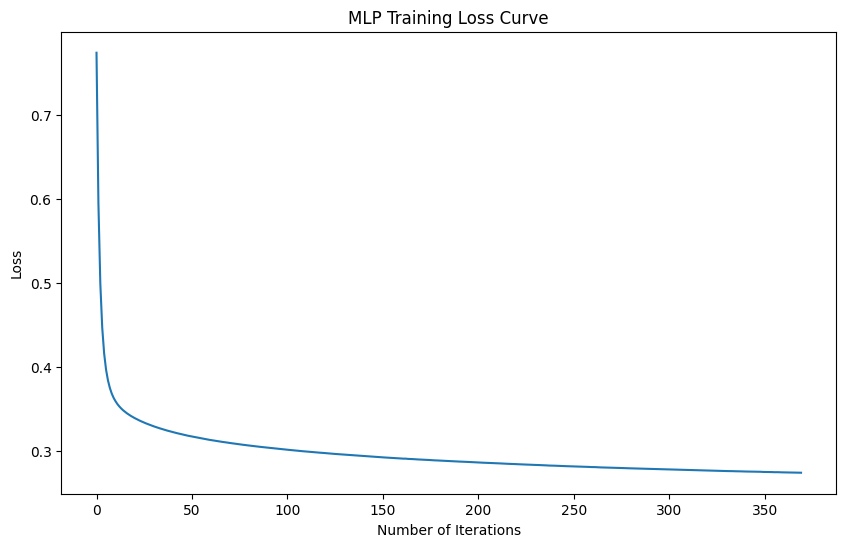

In [ ]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(initial_model.loss_curve_)
plt.title("MLP Training Loss Curve")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Find indices where predictions are incorrect
incorrect_indices = np.where(initial_y_pred != y_test)[0]

# Select up to 10 random indices from the incorrect predictions
num_samples_to_show = min(10, len(incorrect_indices))
random_incorrect_indices = np.random.choice(incorrect_indices, num_samples_to_show, replace=False)

for i in random_incorrect_indices:
    print(f"Sample Index: {i}, Predicted: {initial_y_pred[i]}, Actual: {y_test[i]}")

Sample Index: 1533, Predicted: -1, Actual: 1
Sample Index: 2797, Predicted: -1, Actual: 1
Sample Index: 2647, Predicted: -1, Actual: 1
Sample Index: 4335, Predicted: 1, Actual: -1
Sample Index: 223, Predicted: -1, Actual: 1
Sample Index: 875, Predicted: -1, Actual: 1
Sample Index: 3179, Predicted: 1, Actual: -1
Sample Index: 400, Predicted: -1, Actual: 1
Sample Index: 1886, Predicted: 1, Actual: -1
Sample Index: 611, Predicted: -1, Actual: 1


In [ ]:
# View the classification report
class_report = classification_report(y_test, initial_y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

          -1       0.89      0.91      0.90      4004
           1       0.68      0.63      0.65      1206

    accuracy                           0.85      5210
   macro avg       0.79      0.77      0.78      5210
weighted avg       0.84      0.85      0.84      5210



In [ ]:
# !! This block will take around an hour to run !!
# Use GridSearch to find the best hyperparameters
param_grid = {
    'activation': ['tanh', 'relu'],
    'hidden_layer_sizes': [8, 16, 32],
    'max_iter': [200, 250, 300, 350],
    'learning_rate_init': [0.01, 0.001, 0.0001],
    'alpha': [0.1, 0.2, 0.3]
}
grid = GridSearchCV(estimator = initial_model, param_grid = param_grid, cv = 2, verbose = 2)
grid.fit(X_train, y_train)

Fitting 2 folds for each of 216 candidates, totalling 432 fits
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   2.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   4.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   2.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   1.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=300; total time=   1.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=300; total time=   1.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=350; total time=   1.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=350; total time=   2.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=200; total time=   6.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=200; total time=   7.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=250; total time=   6.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=250; total time=   9.1s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=300; total time=   6.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=300; total time=   9.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=350; total time=   7.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=350; total time=   8.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=  12.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   7.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   6.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   8.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   7.1s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   8.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   7.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   7.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.01, max_iter=200; total time=   2.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   8.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   8.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=  10.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=  11.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=  12.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=  13.0s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=  11.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=  13.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   8.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   8.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=  11.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=  11.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=  13.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=  13.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=  15.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=  15.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   8.1s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   3.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=250; total time=   8.0s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=250; total time=   3.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=300; total time=   5.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=300; total time=   6.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_si

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  17.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  18.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  24.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  23.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  27.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  22.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  30.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  22.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  20.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  17.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  23.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  21.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  29.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  28.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  34.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  31.2s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   1.2s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   3.3s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   1.7s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   2.7s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=300; total time=   1.2s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=300; total time=   2.7s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=350; total time=   1.3s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, le

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=200; total time=   6.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=200; total time=   7.3s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=250; total time=   8.0s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=250; total time=   7.9s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=300; total time=   7.5s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=300; total time=   8.1s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=350; total time=   8.5s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=350; total time=   7.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   7.3s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   6.1s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   7.6s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   6.2s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   7.8s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   6.1s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   7.8s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   6.3s
[CV] END activation=tanh, alpha=0.2, hidden_laye

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   8.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   9.0s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   9.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=  10.3s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   9.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=  13.0s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   9.7s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=  13.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   9.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   8.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=  11.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=  11.1s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=  11.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=  12.9s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=  11.5s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=  12.9s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   4.7s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   3.5s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=250; total time=   7.6s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=250; total time=   3.5s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=300; total time=   7.4s
[CV] END activation=tanh, alpha=0.2, hidden_layer_

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  17.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  17.2s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  22.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  23.4s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  19.9s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  24.4s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  20.2s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  25.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  17.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  20.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  20.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  23.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  27.1s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  26.3s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  30.0s
[CV] END activation=tanh, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  26.6s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   1.2s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   2.6s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   1.4s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   3.3s
[CV] END activation=tanh, alpha=0.3, hidden_layer_si

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   8.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   9.4s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   9.9s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   8.0s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   9.9s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   9.0s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   9.2s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   8.7s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   9.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   8.7s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=   8.5s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=  10.2s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=   9.7s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=   8.6s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=   9.0s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=   9.7s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   2.9s
[CV] END activation=tanh, alpha=0.3, hidde

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  17.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  20.0s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  21.1s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  23.4s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  20.3s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  23.9s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  23.0s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  21.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  20.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  17.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  23.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  21.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  27.4s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  26.6s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  30.7s
[CV] END activation=tanh, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  26.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   1.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   1.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   2.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_si

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   5.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   5.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   7.0s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   7.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   6.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   7.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   6.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   7.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.01, max_iter=200; total time=   2.5s
[CV] END activation=relu, alpha=0.1, hidden_layer

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   7.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   6.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   8.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   9.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   8.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   9.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   9.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   8.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   7.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   6.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=   9.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=   8.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=   8.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=   9.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=   9.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=   9.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   5.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   4.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=250; total time=   7.5s
[CV] END activation=relu, alpha=0.1, hidden_la

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  13.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  11.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  18.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  14.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  15.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  14.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  15.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  14.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  13.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  13.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  15.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  15.7s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  21.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  18.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  23.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  20.7s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   2.4s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   1.6s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   1.9s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   1.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=300; total time=   1.9s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=300; total time=   1.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8,

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=200; total time=   6.5s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=200; total time=   5.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=250; total time=   6.5s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=250; total time=   5.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=300; total time=   6.6s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=300; total time=   5.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=350; total time=   5.5s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=350; total time=   6.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   5.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   6.6s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   6.4s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   7.6s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   6.8s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   8.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   7.0s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   7.0s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.01, max_iter=200; total time=   2.7s
[CV] END activation=relu, alpha=0.2, hidden_layer

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   6.9s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   6.5s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   7.4s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   8.4s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   6.7s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   8.0s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   6.9s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   8.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   6.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   7.0s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=   8.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=   7.6s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=   9.6s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=   9.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=   8.9s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=   9.4s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   4.3s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   5.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=250; total time=   4.1s
[CV] END activation=relu, alpha=0.2, hidden_la

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  13.0s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=200; total time=  12.0s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  15.3s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=250; total time=  11.9s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  15.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=300; total time=  11.8s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  15.1s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=350; total time=  11.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  13.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  13.1s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  15.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  15.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  20.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  18.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  24.0s
[CV] END activation=relu, alpha=0.2, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  22.7s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   1.8s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=200; total time=   1.4s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   1.2s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=250; total time=   1.3s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=300; total time=   1.2s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.01, max_iter=300; total time=   1.3s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8,

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   6.3s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=200; total time=   5.4s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   7.4s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=250; total time=   6.7s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   7.4s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=300; total time=   6.9s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   6.9s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=8, learning_rate_init=0.0001, max_iter=350; total time=   7.6s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.01, max_iter=200; total time=   1.8s
[CV] END activation=relu, alpha=0.3, hidden_layer

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=200; total time=   7.8s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   5.9s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=250; total time=   7.5s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   6.4s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=300; total time=   7.8s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   5.9s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=350; total time=   7.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   6.2s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=200; total time=   7.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=   8.5s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=250; total time=   8.3s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=   9.7s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=300; total time=   8.9s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=   8.5s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=16, learning_rate_init=0.0001, max_iter=350; total time=   9.0s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   2.3s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=200; total time=   2.4s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.01, max_iter=250; total time=   5.7s
[CV] END activation=relu, alpha=0.3, hidden_la

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  12.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=200; total time=  13.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  19.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=250; total time=  15.8s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  18.4s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=300; total time=  21.6s


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  21.2s
[CV] END activation=relu, alpha=0.3, hidden_layer_sizes=32, learning_rate_init=0.0001, max_iter=350; total time=  23.3s


GridSearchCV(cv=2,
             estimator=MLPClassifier(alpha=0.16, hidden_layer_sizes=16,
                                     learning_rate_init=0.0001,
                                     random_state=42),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.1, 0.2, 0.3],
                         'hidden_layer_sizes': [8, 16, 32],
                         'learning_rate_init': [0.01, 0.001, 0.0001],
                         'max_iter': [200, 250, 300, 350]},
             verbose=2)

In [ ]:
# Print the best sscore and the parameters used for that score
print(grid.best_score_)
print(grid.best_params_)

0.8533448507534311
{'activation': 'relu', 'alpha': 0.2, 'hidden_layer_sizes': 16, 'learning_rate_init': 0.0001, 'max_iter': 250}


In [13]:
# Create a model based on the best hyperparemeters
# activation = relu
# hidden layer size = 16
# iterations = 250
# learning rate = 0.0001
# alpha = 0.2
# shuffle = True (default)
# optimizer = Adam (default)

model = MLPClassifier(activation= 'relu', hidden_layer_sizes=16, max_iter=250, learning_rate_init = 0.0001, alpha = 0.2, shuffle=True, random_state=42)

In [14]:
# Fit the model on the training data
model.fit(X_train, y_train)

MLPClassifier(alpha=0.2, hidden_layer_sizes=16, learning_rate_init=0.0001,
              max_iter=250, random_state=42)

In [15]:
# Make predictions for the test set
y_pred = model.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 85.11%


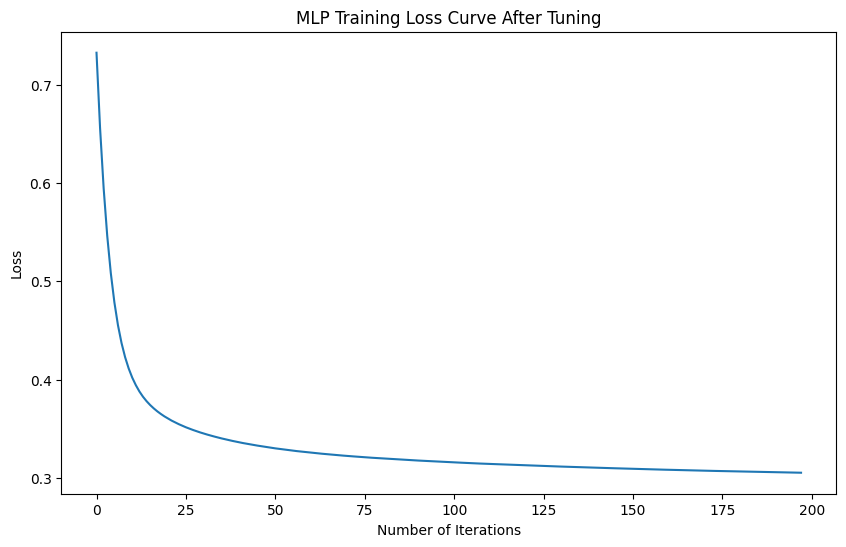

In [ ]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(model.loss_curve_)
plt.title("MLP Training Loss Curve After Tuning")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [16]:
# View the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

          -1       0.89      0.92      0.90      4004
           1       0.70      0.62      0.66      1206

    accuracy                           0.85      5210
   macro avg       0.80      0.77      0.78      5210
weighted avg       0.85      0.85      0.85      5210



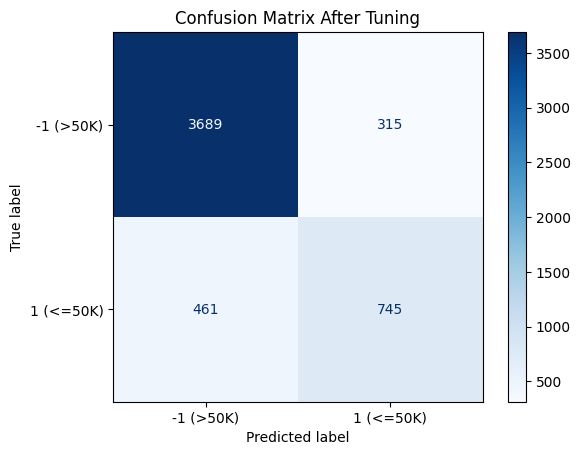

In [17]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 1 if x == '>50K' else -1
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1 (>50K)', '1 (<=50K)'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix After Tuning')
plt.show()